In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from category_encoders import TargetEncoder, OneHotEncoder
from scipy import stats

In [9]:
data = pd.read_csv('data_cleaned.csv',index_col=0)
data.head()

,price,bed,bath,house_size,city_enc,zip_enc,state_Puerto Rico,state_Massachusetts,state_Connecticut,state_New Jersey,state_New York,state_New Hampshire,state_Vermont,state_Rhode Island,state_Wyoming,state_Maine,state_Georgia,state_Pennsylvania,state_Delaware
0,105000.0,3.0,2.0,920.0,280247.482950,280247.482950,1,0,0,0,0,0,0,0,0,0,0,0,0
1,80000.0,4.0,2.0,1527.0,280247.482950,280247.482950,1,0,0,0,0,0,0,0,0,0,0,0,0
2,67000.0,2.0,1.0,748.0,114611.845711,113752.971131,1,0,0,0,0,0,0,0,0,0,0,0,0
3,145000.0,4.0,2.0,1800.0,199673.107143,168305.581318,1,0,0,0,0,0,0,0,0,0,0,0,0
5,179000.0,4.0,3.0,2520.0,196619.034149,144958.974359,1,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
y = np.array(data['price'])
X = data.drop('price', axis=1)
X_list = list(X.columns)
X = np.array(X)

In [12]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
# tune hyperparameters
n_estimators = [100, 200, 300, 500, 800]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 28, 52, 76, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         800]},
                   random_state=42, verbose=2)

In [15]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [18]:
y_pred = rf_random.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R^2 : % f" %(r2))

R^2 :  0.838542


In [23]:
importance = rf_random.best_estimator_.feature_importances_
importance

array([4.73930577e-02, 1.33071042e-01, 1.83670818e-01, 2.22503327e-01,
       3.51801501e-01, 1.36077107e-03, 4.16825118e-03, 3.76884486e-03,
       4.13703837e-03, 4.37965576e-02, 4.58853015e-04, 4.05148827e-04,
       7.12242369e-04, 0.00000000e+00, 6.12668755e-04, 2.40152570e-06,
       1.94537038e-03, 1.92106368e-04])

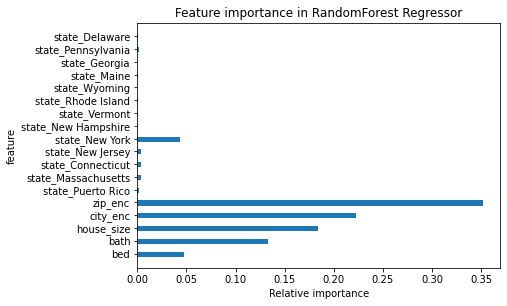

<Figure size 360x360 with 0 Axes>

In [30]:
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars
ind = np.arange(len(importance)) # the x locations for the groups
ax.barh(ind, importance, width)
ax.set_yticks(ind+width/10)
ax.set_yticklabels(X_list, minor=False)
plt.title('Feature importance in RandomForest Regressor')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [2]:
# try using lat and long instead of zipcode
data = pd.read_csv('data_long_lat.csv',index_col=0)
data.head()

,price,bed,bath,city,state,house_size,latitude,longitude
0,105000.0,3.0,2.0,Adjuntas,Puerto Rico,920.0,18.1627,-66.7221
1,80000.0,4.0,2.0,Adjuntas,Puerto Rico,1527.0,18.1627,-66.7221
2,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,748.0,18.0525,-66.5066
3,145000.0,4.0,2.0,Ponce,Puerto Rico,1800.0,18.0111,-66.6141
5,179000.0,4.0,3.0,San Sebastian,Puerto Rico,2520.0,18.4724,-66.7157


In [4]:
# target encoding
data["city_enc"] = TargetEncoder().fit_transform(data["city"], data["price"])

In [5]:
# one hot encoding
states_encoded = OneHotEncoder(use_cat_names=True).fit_transform(data["state"])
data = pd.concat([data, states_encoded], axis=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [12]:
data = data.drop(["city","state"], axis=1)

In [13]:
data.head()

,price,bed,bath,house_size,latitude,longitude,city_enc,state_Puerto Rico,state_Massachusetts,state_Connecticut,state_New Jersey,state_New York,state_New Hampshire,state_Vermont,state_Rhode Island,state_Wyoming,state_Maine,state_Georgia,state_Pennsylvania,state_Delaware
0,105000.0,3.0,2.0,920.0,18.1627,-66.7221,280272.391358,1,0,0,0,0,0,0,0,0,0,0,0,0
1,80000.0,4.0,2.0,1527.0,18.1627,-66.7221,280272.391358,1,0,0,0,0,0,0,0,0,0,0,0,0
2,67000.0,2.0,1.0,748.0,18.0525,-66.5066,114611.846280,1,0,0,0,0,0,0,0,0,0,0,0,0
3,145000.0,4.0,2.0,1800.0,18.0111,-66.6141,199673.107143,1,0,0,0,0,0,0,0,0,0,0,0,0
5,179000.0,4.0,3.0,2520.0,18.4724,-66.7157,196619.034718,1,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
y = np.array(data['price'])
X = data.drop('price', axis=1)
X_list = list(X.columns)
X = np.array(X)

In [15]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 28, 52, 76, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         800]},
                   random_state=42, verbose=2)

In [17]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [18]:
y_pred = rf_random.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R^2 : % f" %(r2))

R^2 :  0.827212


In [161]:
# try with new york and new jersey data
data = pd.read_csv('realtor-data.csv')
data.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [162]:
# drop duplicate values
data.drop_duplicates(inplace=True)
# drop columns that won't be used
data = data.drop(["status", "acre_lot", "full_address", "street", "sold_date"], axis=1)
# drop missing values
data.dropna(how='any', inplace=True)

In [163]:
ny = data[data.state=='New York']
nj = data[data.state=='New Jersey']
data = pd.concat([ny, nj])
data.head()

,price,bed,bath,city,state,zip_code,house_size
30149,175000.0,3.0,1.0,Berlin,New York,12022.0,1176.0
54248,425000.0,3.0,2.0,Claverack,New York,12521.0,1600.0
54258,225000.0,4.0,2.0,Copake,New York,12521.0,1239.0
54259,419000.0,3.0,3.0,Copake,New York,12516.0,1800.0
54262,365000.0,3.0,2.0,Copake,New York,12517.0,1482.0


In [164]:
# remove outlier (greater than 3 standard deviations)
data = data[np.abs(stats.zscore(data['price'])) < 3]
data = data[np.abs(stats.zscore(data['bed'])) < 3]
data = data[np.abs(stats.zscore(data['bath'])) < 3]
data = data[np.abs(stats.zscore(data['house_size'])) < 3]
data.shape

(32291, 7)

In [165]:
data = data.replace('New York City','New York')

In [166]:
data["zip_code"] = data["zip_code"].apply(str)

In [167]:
# target encoding
data["city_enc"] = TargetEncoder().fit_transform(data["city"], data["price"])
data["zip_enc"] = TargetEncoder().fit_transform(data["zip_code"], data["price"])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_sample

In [168]:
# one hot encoding
states_encoded = OneHotEncoder(use_cat_names=True).fit_transform(data["state"])
data = pd.concat([data, states_encoded], axis=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [169]:
data

,price,bed,bath,city,state,zip_code,house_size,city_enc,zip_enc,state_New York,state_New Jersey
30149,175000.0,3.0,1.0,Berlin,New York,12022.0,1176.0,280660.187500,4.490394e+05,1,0
54248,425000.0,3.0,2.0,Claverack,New York,12521.0,1600.0,444007.828515,1.405033e+06,1,0
54258,225000.0,4.0,2.0,Copake,New York,12521.0,1239.0,679579.960016,1.405033e+06,1,0
54259,419000.0,3.0,3.0,Copake,New York,12516.0,1800.0,679579.960016,6.826080e+05,1,0
54262,365000.0,3.0,2.0,Copake,New York,12517.0,1482.0,679579.960016,5.271485e+05,1,0
...,...,...,...,...,...,...,...,...,...,...,...
904198,718000.0,2.0,3.0,Metuchen,New Jersey,8840.0,3300.0,598280.161290,5.570637e+05,0,1
904201,575000.0,2.0,2.0,New Brunswick,New Jersey,8901.0,1296.0,384935.288889,3.850237e+05,0,1
904288,494990.0,3.0,3.0,Cliffwood,New Jersey,7721.0,1584.0,467231.889755,4.218195e+05,0,1
904320,569990.0,3.0,4.0,Cliffwood,New Jersey,7721.0,1917.0,467231.889755,4.218195e+05,0,1


In [170]:
# data.to_csv('nynj_data.csv', index=False)

In [171]:
nynj = data.drop(["city","state","zip_code"], axis=1)
nynj.head()

,price,bed,bath,house_size,city_enc,zip_enc,state_New York,state_New Jersey
30149,175000.0,3.0,1.0,1176.0,280660.187500,4.490394e+05,1,0
54248,425000.0,3.0,2.0,1600.0,444007.828515,1.405033e+06,1,0
54258,225000.0,4.0,2.0,1239.0,679579.960016,1.405033e+06,1,0
54259,419000.0,3.0,3.0,1800.0,679579.960016,6.826080e+05,1,0
54262,365000.0,3.0,2.0,1482.0,679579.960016,5.271485e+05,1,0


In [172]:
y = np.array(nynj['price'])
X = nynj.drop('price', axis=1)
X_list = list(X.columns)
X = np.array(X)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 42)

In [178]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [10, 30, 50, 70, 100]},
                   random_state=42, verbose=2)

In [179]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [180]:
y_pred = rf_random.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R^2 : % f" %(r2))

R^2 :  0.865731


In [182]:
pickle.dump(rf_random, open('rf_model.pkl', 'wb'))

In [215]:
test = np.array([1, 1, 800, 2853221.61005784, 2338338.88095238, 1, 0])
test2 = np.array([2, 2, 1000, 2853221.61005784, 2338338.88095238, 1, 0])
test3 = np.array([2, 2, 1500, 2853221.61005784, 2338338.88095238, 1, 0])

In [216]:
pickled_model.predict(test.reshape(1,-1))

array([904821.55891156])

In [217]:
pickled_model.predict(test2.reshape(1,-1))

array([1657190.87301587])

In [218]:
pickled_model.predict(test3.reshape(1,-1))

array([1818913.08441558])